### PROYECTO: PREDICCIÓN DE LA TASA DE DESEMPLEO EN COLOMBIA: UN ESTUDIO COMPARATIVO DE MODELOS HÍBRIDOS Y AVANZADOS.

### Modelo SARIMA

### Elaborado por: Yairo Oviedo


<Figure size 1400x700 with 0 Axes>

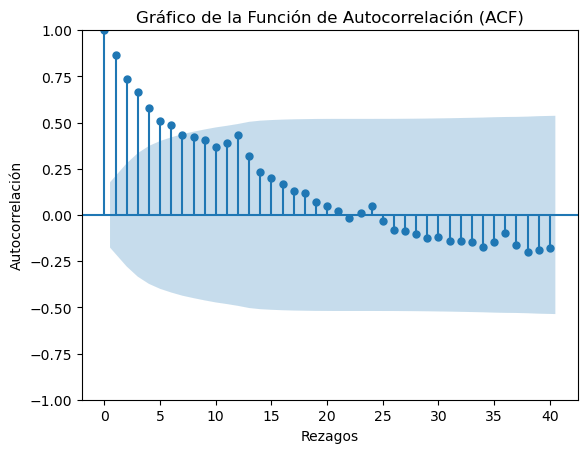

<Figure size 1400x700 with 0 Axes>

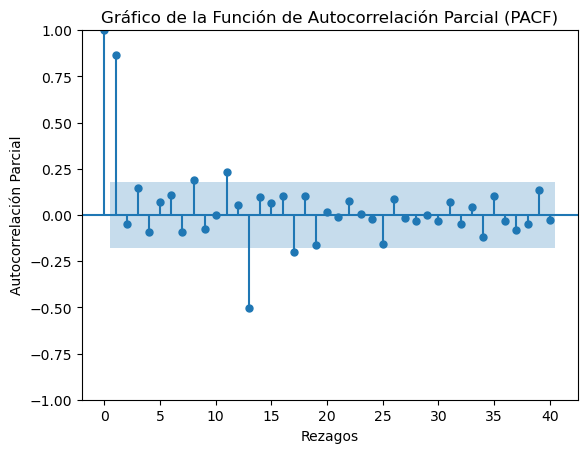

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy import stats

# Cargar datos
file_path = 'TD_BUSQUEDAS_GOOGLE.csv'
df_cleaned = pd.read_csv(file_path, sep=";")
df_cleaned['Mes'] = pd.to_datetime(df_cleaned['Mes'], format='%Y-%m')
df_cleaned.set_index('Mes', inplace=True)

# Convertir columnas de tipo object a float si es necesario
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = df_cleaned[col].str.replace(',', '.').astype(float)

# Filtrar el DataFrame para el rango de fechas
fecha_inicio = '2014-01-01'
fecha_fin = '2024-03-01'
df_cleaned = df_cleaned.loc[fecha_inicio:fecha_fin]

# Extraer la serie temporal de la tasa de desempleo
ts_unemployment = df_cleaned['Tasa Desempleo']

plt.figure(figsize=(14, 7))
acf_plot = plot_acf(ts_unemployment, lags=40)
plt.title('Gráfico de la Función de Autocorrelación (ACF)')
plt.xlabel('Rezagos')
plt.ylabel('Autocorrelación')
plt.show()

# Graficar PACF
plt.figure(figsize=(14, 7))
pacf_plot = plot_pacf(ts_unemployment, lags=40)
plt.title('Gráfico de la Función de Autocorrelación Parcial (PACF)')
plt.xlabel('Rezagos')
plt.ylabel('Autocorrelación Parcial')
plt.show()

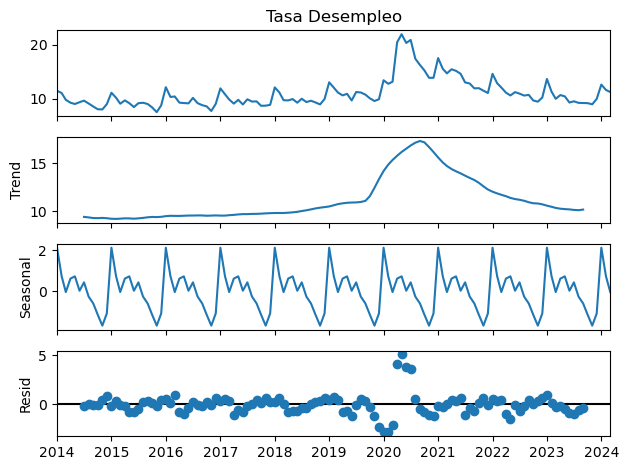

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=360.114, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=411.709, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=374.655, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=389.321, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=409.730, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=373.034, Time=0.83 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=363.681, Time=1.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=412.307, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.43

In [135]:

# Descomposición de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_unemployment, model='additive')
decomposition.plot()
plt.show()

# División de los datos en entrenamiento y prueba
train_size = int(len(ts_unemployment) * 0.95)
train, test = ts_unemployment.iloc[:train_size], ts_unemployment.iloc[train_size:]

# Identificación del modelo SARIMA usando auto_arima
# Uso de auto_arima para seleccionar el mejor modelo SARIMA
model = auto_arima(train, seasonal=True, m=12, trace=True, stepwise=True, approximation=False)
order = model.order
print(order)
seasonal_order = model.seasonal_order
print(seasonal_order)
# Ajuste del modelo SARIMA
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Resumen del modelo
print(sarima_result.summary())

# Predicción
forecast = sarima_result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Excluir el primer valor en las métricas debido a la diferenciación
train_fitted = sarima_result.fittedvalues[1:]
train_adjusted = train[1:]

# Evaluación del modelo en datos de prueba
rmse = np.sqrt(mean_squared_error(test, forecast_values))
mae = mean_absolute_error(test, forecast_values)
mape = np.mean(np.abs((test - forecast_values) / test)) * 100
r2 = r2_score(test, forecast_values)

print(f'RMSE (Test): {rmse}')
print(f'MAE (Test): {mae}')
print(f'MAPE (Test): {mape}')
print(f'R^2 (Test): {r2}')

# Calcular las métricas en el conjunto de entrenamiento excluyendo el primer valor
rmse_train = np.sqrt(mean_squared_error(train_adjusted, train_fitted))
mae_train = mean_absolute_error(train_adjusted, train_fitted)
mape_train = np.mean(np.abs((train_adjusted - train_fitted) / train_adjusted)) * 100
r2_train = r2_score(train_adjusted, train_fitted)

print(f'RMSE (Train): {rmse_train}')
print(f'MAE (Train): {mae_train}')
print(f'MAPE (Train): {mape_train}')
print(f'R^2 (Train): {r2_train}')



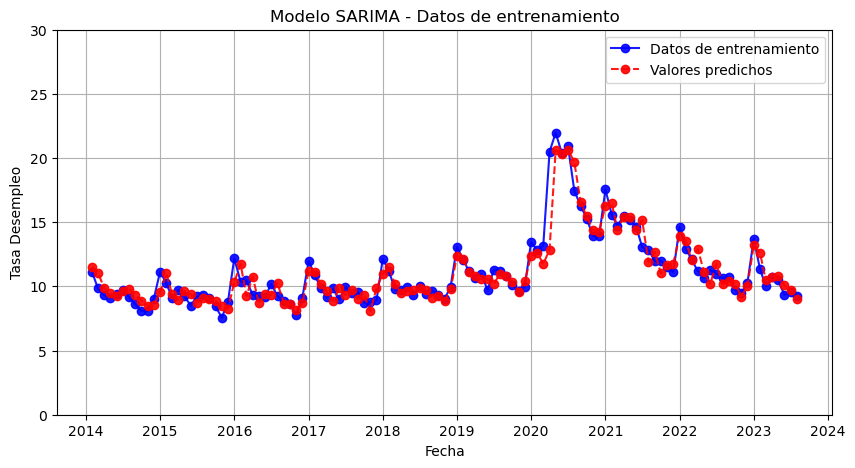

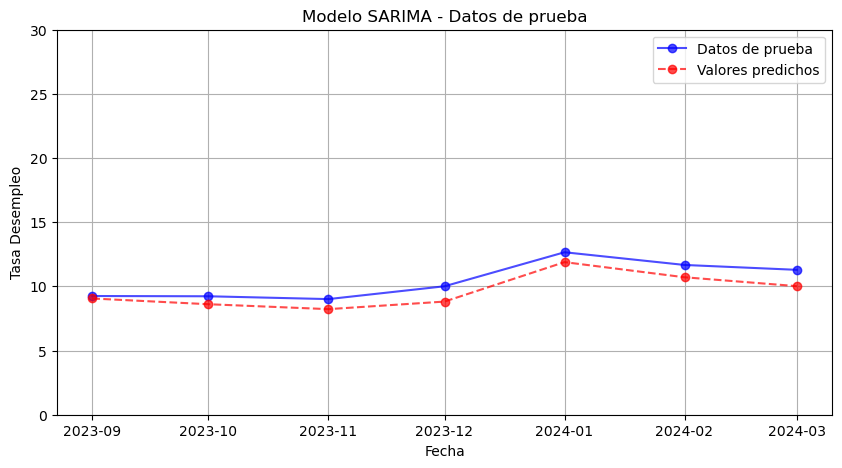

In [136]:
# Gráfico de los datos de entrenamiento con valores reales y predichos
plt.figure(figsize=(10, 5))
plt.plot(train_adjusted.index, train_adjusted, label='Datos de entrenamiento', alpha=0.9, marker='o', color='blue', linestyle='-')
plt.plot(train_adjusted.index, train_fitted, label='Valores predichos', alpha=0.9, marker='o', color='red', linestyle='--')
plt.title('Modelo SARIMA - Datos de entrenamiento')
plt.ylim(0, 30)  # Ajustar el límite del eje y
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de los datos de prueba con valores reales y predichos
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Datos de prueba', alpha=0.7, marker='o', color='blue', linestyle='-')
plt.plot(test.index, forecast_values, label='Valores predichos', alpha=0.7, marker='o', color='red', linestyle='--')
#plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.2)
plt.title('Modelo SARIMA - Datos de prueba')
plt.ylim(0, 30)  # Ajustar el límite del eje y
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.legend()
plt.grid(True)
plt.show()

Shapiro-Wilk Test: W=0.5692588090896606, p-value=6.977238688382737e-17


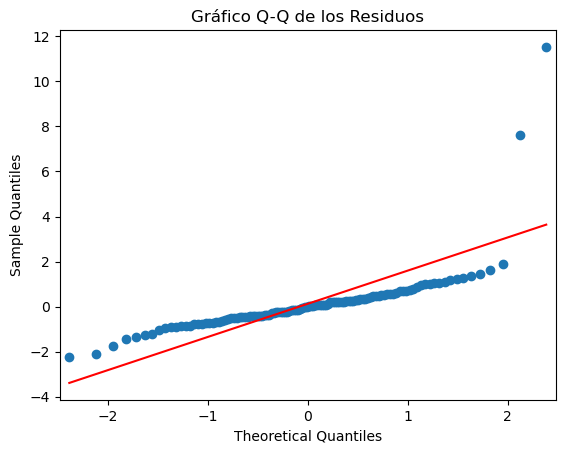

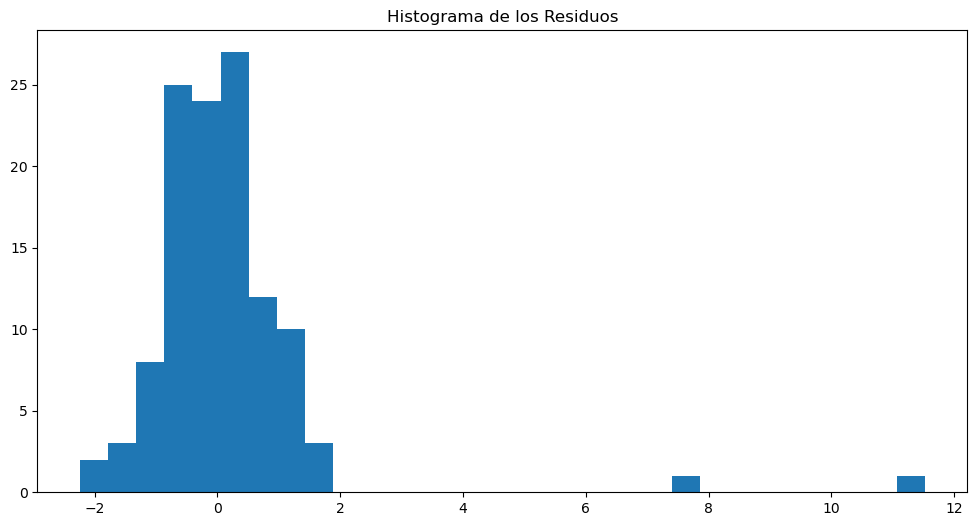

In [145]:
# Graficar los residuos
residuals = sarima_result.resid

# Prueba de normalidad (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# QQ- plot
sm.qqplot(residuals, line='s')
plt.title('Gráfico Q-Q de los Residuos')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30)
plt.title('Histograma de los Residuos')
plt.show()

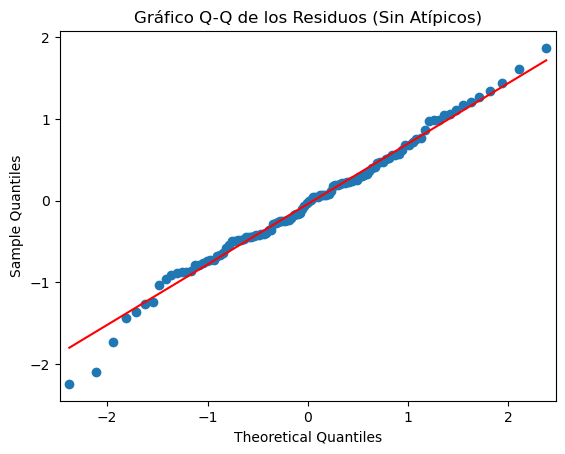

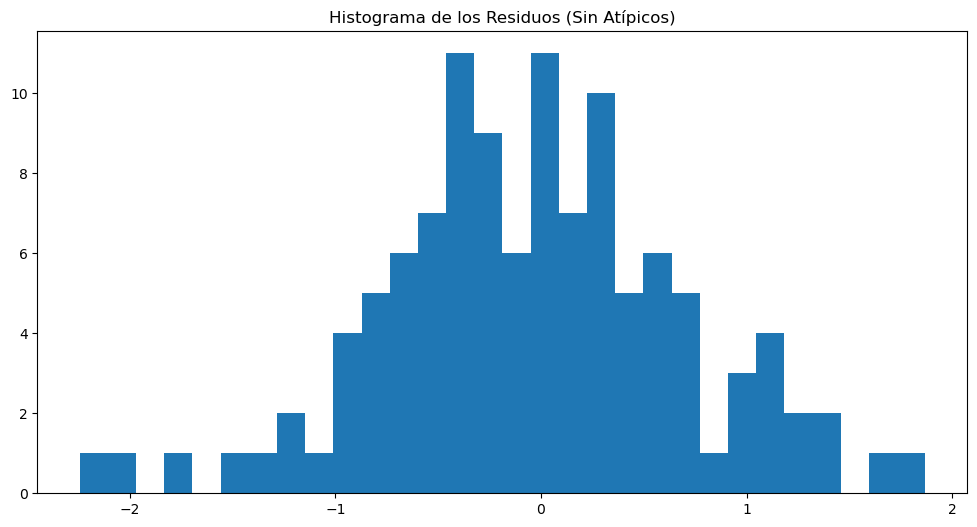

Shapiro-Wilk Test: W=0.9912244081497192, p-value=0.6824031472206116


In [141]:
# Excluir los residuos atípicos
residuals_no_outliers = residuals[np.abs(residuals - np.mean(residuals)) < 3 * np.std(residuals)]

# Gráficas sin residuos atípicos
#plt.figure(figsize=(12, 6))
#plt.subplot(211)
#plt.plot(residuals_no_outliers)
#plt.title('Residuos del Modelo (Sin Atípicos)')

#plt.subplot(212)
sm.qqplot(residuals_no_outliers, line='s')
plt.title('Gráfico Q-Q de los Residuos (Sin Atípicos)')
plt.show()

# Histograma de los residuos sin atípicos
plt.figure(figsize=(12, 6))
plt.hist(residuals_no_outliers, bins=30)
plt.title('Histograma de los Residuos (Sin Atípicos)')
plt.show()

# Prueba de normalidad (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals_no_outliers)
print(f'Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')


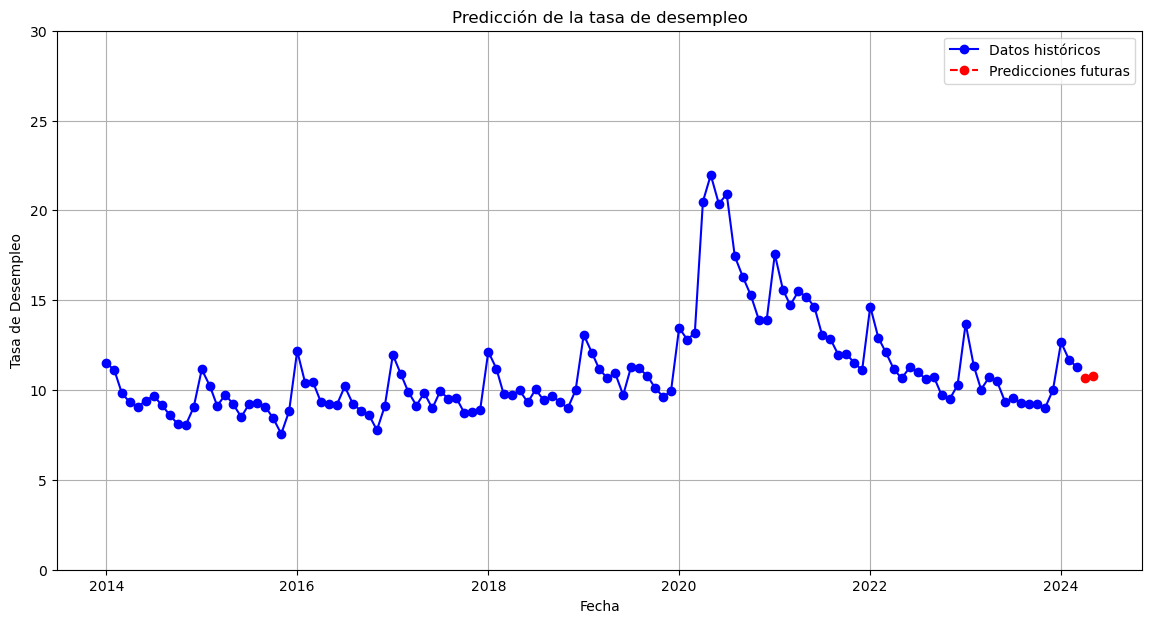

In [139]:
# Proyección de 2 nuevos datos de la serie
forecast_future = sarima_result.get_forecast(steps=len(test) + 2)
forecast_values_future = forecast_future.predicted_mean[-2:]
conf_int_future = forecast_future.conf_int().iloc[-2:]
# Graficar los datos históricos y las predicciones futuras
plt.figure(figsize=(14, 7))
plt.plot(ts_unemployment.index, ts_unemployment.values, label='Datos históricos', marker='o', color='blue', linestyle='-')
predicted_dates = [ts_unemployment.index[-1] + pd.DateOffset(months=i+1) for i in range(2)]
plt.plot(predicted_dates, forecast_values_future, label='Predicciones futuras', marker='o', color='red', linestyle='--')

# Formatear gráfico
plt.title('Predicción de la tasa de desempleo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()